In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import savgol_filter
from pathlib import Path
import seaborn as sns
#all packages used

# Load and Prepare Data

In [90]:
input_files = [r"trajectories_WT_2024-11-12.csv", r"trajectories_ΔfleN_2024-11-12.csv", r"trajectories_SPa1869_2024-11-12.csv"]  # List of CSV files

metrics_raw = {k: [] for k in ['distances', 'angles', 'dist_in_microns', 'num_turns', 'turns_in_microns', 'total_distance']}
metrics_smooth = {k: [] for k in metrics_raw.keys()}
labels_raw = {k: [] for k in metrics_raw.keys()}
labels_smooth = {k: [] for k in metrics_raw.keys()}


# Smoothing Function

In [91]:
def apply_savgol_filter(df, window_length=5, polyorder=1):
    df = df.copy().sort_values('frame').reset_index(drop=True)
    for axis in ['x', 'y', 'z']:
        if len(df) >= window_length:
            df[axis] = savgol_filter(df[axis], window_length=window_length, polyorder=polyorder)
    return df
#window you can change it, 5 does not over or undersample

# Turn Calculation

In [92]:
def calculate_turns(df, turn_threshold=np.deg2rad(15)):#has to be more than 15degrees to be consider a turn
    coords = df[['x', 'y', 'z']].values
    vectors = np.diff(coords, axis=0)
    if len(vectors) < 2:
        return np.array([]), 0, []
    norms = np.linalg.norm(vectors, axis=1)
    valid_indices = [i for i in range(len(vectors) - 1) if norms[i] > 0 and norms[i + 1] > 0]
    angles = []
    turn_points = []
    for i in valid_indices:
        v1 = vectors[i]
        v2 = vectors[i + 1]
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
        angles.append(angle)
        if angle > turn_threshold:
            turn_points.append(i + 1)
    return np.array(angles), len(turn_points), turn_points
#do not touch!

# Pixel to micron conversion

In [93]:
def micron_conversion(df):
    # Use pixel to micron conversion directly
    return 0.559 #change this if necessary

# Distance Calculation 

In [94]:
def calculate_distance_traveled(df):
    coords = df[['x', 'y', 'z']].values
    distances = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    return distances, np.mean(distances), np.std(distances)

# Filtering low velocity function

In [95]:
def filter_low_velocity_frames(df, velocity_threshold=1.0):
    if 'v' not in df.columns:
        return df  # If no velocity column, do not filter
    initial_count = len(df)
    df_filtered = df[df['v'] >= velocity_threshold].copy()
    filtered_count = initial_count - len(df_filtered)
    if filtered_count > 0:
        print(f"Filtered {filtered_count} low-velocity frames from particle.")
    return df_filtered
#velocity threshold of 1. 1 micrometer per second or bigger 

# Particle Processing Function

In [96]:
def process_particle(df_particle, smoothing=True, window_length=5, polyorder=1, turn_threshold=np.deg2rad(15)):
    df_particle = filter_low_velocity_frames(df_particle, velocity_threshold=1.0)
    if len(df_particle) < 3:
        return None
    df_particle = df_particle.sort_values('frame').reset_index(drop=True)
    if smoothing and len(df_particle) >= window_length:
        df_particle = apply_savgol_filter(df_particle, window_length, polyorder)
    cell_microns = micron_conversion(df_particle)
    distances, _, _ = calculate_distance_traveled(df_particle)
    angles, num_turns, _ = calculate_turns(df_particle, turn_threshold)
    total_distance = distances.sum()
    dist_in_microns = total_distance / cell_microns
    turns_in_microns = num_turns / cell_microns
    return {
        'distances': distances,
        'angles': np.degrees(angles),
        'dist_in_microns': [dist_in_microns],
        'num_turns': [num_turns],
        'turns_in_microns': [turns_in_microns],
        'total_distance': [total_distance]
    }
#takes eerything and collects it. 

# Process All Input Files

In [97]:
from collections import defaultdict
# Store up to 10 particles per condition
example_trajectories = []
condition_counts = defaultdict(int)

# === Print Summary of Stored Example Trajectories ===
def print_saved_trajectories():
    print("Saved Example Trajectories (Condition + Particle ID):")
    for pid, raw_df, _ in example_trajectories:
        condition = Path(raw_df.attrs.get('source', 'unknown')).stem.split("_")[1] if 'source' in raw_df.attrs else 'unknown'
        print(f"  Condition: {condition:<10}  Particle ID: {pid}")

condition_counts = defaultdict(int)
for file in input_files:
    df = pd.read_csv(file)
    df = df[df['interpolated'] == False].copy()
    particle_groups = df.groupby('particle')
    label = Path(file).stem

    

        # Randomize particle order before sampling
    particle_list = list(particle_groups)
    np.random.shuffle(particle_list)

    for particle_id, group in particle_list:
        condition = Path(file).stem.split("_")[1]
        if condition_counts[condition] < 10:
            temp_raw = group.copy()
            temp_raw.attrs['source'] = file
            example_trajectories.append((particle_id, temp_raw, apply_savgol_filter(temp_raw.copy())))
            condition_counts[condition] += 1

        # Raw data
        result_raw = process_particle(group, smoothing=False)
        if result_raw:
            for key in metrics_raw:
                metrics_raw[key].extend(result_raw[key])
                labels_raw[key].extend([label] * len(result_raw[key]))
        # Smoothed data
        result_smooth = process_particle(group, smoothing=True, window_length=5, polyorder=1)
        if result_smooth:
            for key in metrics_smooth:
                metrics_smooth[key].extend(result_smooth[key])
                labels_smooth[key].extend([label] * len(result_smooth[key]))

Filtered 5 low-velocity frames from particle.
Filtered 5 low-velocity frames from particle.
Filtered 9 low-velocity frames from particle.
Filtered 9 low-velocity frames from particle.
Filtered 9 low-velocity frames from particle.
Filtered 9 low-velocity frames from particle.
Filtered 6 low-velocity frames from particle.
Filtered 6 low-velocity frames from particle.
Filtered 3 low-velocity frames from particle.
Filtered 3 low-velocity frames from particle.
Filtered 8 low-velocity frames from particle.
Filtered 8 low-velocity frames from particle.
Filtered 4 low-velocity frames from particle.
Filtered 4 low-velocity frames from particle.
Filtered 7 low-velocity frames from particle.
Filtered 7 low-velocity frames from particle.
Filtered 4 low-velocity frames from particle.
Filtered 4 low-velocity frames from particle.
Filtered 9 low-velocity frames from particle.
Filtered 9 low-velocity frames from particle.
Filtered 8 low-velocity frames from particle.
Filtered 8 low-velocity frames fro

# Histogram, PDF, and CDF Colored by Condition

In [109]:
import os
#plot_output_dir = "trajectory_plots_microns_05_07_25" # Change output folder here
plot_output_dir = "PAPER_Total-distance-per-trajectory-wt-DfleN-SON2-07-01/"
os.makedirs(plot_output_dir, exist_ok=True)
def plot_histogram_pdf_cdf(data, labels, title, xlabel, bins=50):
    min_len = min(len(data), len(labels))
    label_map = {
        'trajectories_WT_2024-11-12': 'WT',
        'trajectories_ΔfleN_2024-11-12': 'ΔfleN',
        'trajectories_SPa1869_2024-11-12': 'SON2'
    }
    #df = pd.DataFrame({"value": data[:min_len], "label": labels[:min_len]})
    pretty_labels = [label_map.get(l, l) for l in labels[:min_len]]
    df = pd.DataFrame({"value": data[:min_len], "label": pretty_labels})

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    color_palette = {
    'SON2': '#AFE602',     # dark blue
    'WT': '#90C4FF',    # blue
    'ΔfleN': '#00822C'  # green
    }

    # Histogram
    sns.histplot(data=df, x="value", hue="label", bins=bins, edgecolor="black", alpha=0.6, ax=axs[0],palette=color_palette)
    axs[0].set_title(f"{title} - Histogram")
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel("Count")
    axs[0].grid(True)

    # PDF
    sns.kdeplot(data=df, x="value", hue="label", ax=axs[1],palette=color_palette)
    axs[1].set_title(f"{title} - PDF")
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel("Density")
    axs[1].grid(True)

    # CDF
    for label_name, group in df.groupby("label"):
        sorted_vals = np.sort(group["value"])
        cdf_vals = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
        #axs[2].plot(sorted_vals, cdf_vals, label=label_name)
        axs[2].plot(sorted_vals, cdf_vals, label=label_name, color=color_palette.get(label_name, None))

    axs[2].set_title(f"{title} - CDF")
    axs[2].set_xlabel(xlabel)
    axs[2].set_ylabel("Cumulative Probability")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    fig.savefig(os.path.join(plot_output_dir, f"{title.replace(' ', '_')}.png"))
    plt.close(fig)

# Statistical Tests for Smoothed Metrics

In [60]:
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp
from math import sqrt

def cohens_d(group1, group2, group3):
    n1, n2 = len(group1), len(group2)
    s1, s2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std if pooled_std > 0 else np.nan
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

def perform_stat_tests(metric_name):
    df = pd.DataFrame({
        'value': metrics_smooth[metric_name],
        'label': labels_smooth[metric_name]
    })
    group1 = df[df['label'].str.contains("WT")]['value']
    group2 = df[df['label'].str.contains("ΔfleN")]['value']
    group3 = df[df['label'].str.contains("SPa1869")]['value']
    print(f"{metric_name.upper()} Statistical Comparison:")
    print("Mann-Whitney U:", mannwhitneyu(group1, group2, group3, alternative='two-sided'))
    print("t-test:", ttest_ind(group1, group2,group3, equal_var=False))
    print("KS test:", ks_2samp(group1, group2, group3))
    print("Cohen's d:", cohens_d(group1, group2, group3))

#comparing wt to dfleN

In [61]:
# Run tests for selected metrics
for metric in ["angles", "total_distance", "num_turns", "dist_in_microns"]:
    perform_stat_tests(metric)

ANGLES Statistical Comparison:


TypeError: unhashable type: 'Series'

# Compare Velocity Between Conditions 

In [107]:
def compare_velocity_across_conditions():
    velocity_data = []
    for file in input_files:
        df = pd.read_csv(file)
        df = df[df['interpolated'] == False].copy()
        label = Path(file).stem.split("_")[1]
    
        if 'v' in df.columns:
            for pid, group in df.groupby('particle'):
                group_sorted = group.sort_values('frame')
                velocity_data.extend([(label, v) for v in group_sorted['v'].values])

    velocity_df = pd.DataFrame(velocity_data, columns=["condition", "velocity"])
    print(velocity_df.head())
    plt.figure(figsize=(10, 6))
    
    color_palette = {
    'SPa1869': '#AFE602',     # dark blue
    'WT': '#90C4FF',    # blue
    'ΔfleN': '#00822C'  # green 'ΔfleN', 'WT', 'SPa1869'
    }
    sns.kdeplot(data=velocity_df, x="velocity", hue="condition", fill=True, alpha=0.5, palette=color_palette)
    plt.title("Velocity Distribution by Condition")
    plt.xlabel("Velocity (µm/s)")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_output_dir, "velocity_distribution_by_condition.png"))
    plt.close()

    # CDF plot
    plt.figure(figsize=(10, 6))
    for condition, group in velocity_df.groupby("condition"):
        sorted_vals = np.sort(group["velocity"])
        cdf_vals = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
        #plt.plot(sorted_vals, cdf_vals, label=condition)
        plt.plot(sorted_vals, cdf_vals, label=condition, color=color_palette.get(condition, None))
    plt.title("Velocity CDF by Condition")
    plt.xlabel("Velocity (µm/s)")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_output_dir, "velocity_cdf_by_condition.png"))
    plt.close()

compare_velocity_across_conditions()

  condition   velocity
0        WT  32.161908
1        WT  29.950555
2        WT  27.738519
3        WT  25.556494
4        WT  23.454166


# Compare Distributions for All Metrics

ValueError: Could not interpret value `label` for `hue`. An entry with this name does not appear in `data`.

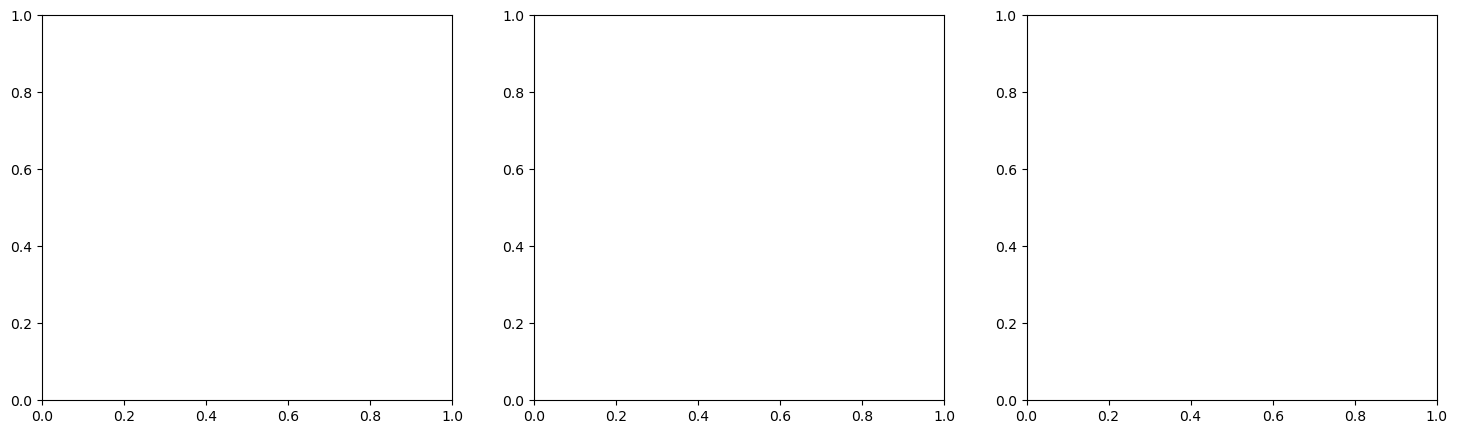

In [110]:
for metric, label in zip(['angles', 'total_distance', 'num_turns', 'dist_in_microns'],
                         ['Angle (degrees)', 'Distance', 'Turns', 'Distance (microns)']):
    
    plot_histogram_pdf_cdf(metrics_raw[metric], labels_raw[metric], f"{metric.replace('_', ' ').title()} per trajectory (Raw)", label)
   
    plot_histogram_pdf_cdf(metrics_smooth[metric], labels_smooth[metric], f"{metric.replace('_', ' ').title()} per trajectory (Smoothed)", label)
   
#they need the loop to do all the grpahs and all

# Velocity Over Time Plot

In [46]:
def plot_velocity_over_time(df, particle_id=None, fps=120):
    df = df.sort_values("frame").reset_index(drop=True).copy()
    if 'v' in df.columns:
        times = df['frame'].values / fps
        velocity = df['v'].values
    else:
        coords = df[['x', 'y', 'z']].values * 0.559
        frame_times = df['frame'].values / fps
        distances = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        velocity = distances * fps
        times = frame_times[1:]

    plt.figure(figsize=(8, 4))
    plt.plot(times, velocity, marker='o', linestyle='-')
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (µm/s)")
    plt.title(f"Velocity Over Time - Particle {particle_id if particle_id is not None else ''}")
    plt.grid(True)
    filename = f"velocity_plot_particle_{particle_id}.png"
    plt.tight_layout()
    plt.savefig(os.path.join(plot_output_dir, filename))
    plt.close()

# Plot Trajectory for Any Given Particle ID and Condition 

In [47]:
def plot_trajectory_by_condition_and_id(condition, particle_id):
    for pid, raw_df, smoothed_df in example_trajectories:
        source_label = Path(raw_df.attrs.get('source', 'unknown')).stem.split("_")[1] if 'source' in raw_df.attrs else 'unknown'
        if source_label == condition and pid == particle_id:
            plot_3d_trajectory_comparison(raw_df, smoothed_df, particle_id=pid)
            plot_velocity_over_time(smoothed_df, particle_id=pid)
            return
    print(f"Particle ID {particle_id} not found in condition {condition}.")

# Plot Example Raw and Smoothed Trajectories

In [48]:
def plot_3d_trajectory_comparison(raw_df, smoothed_df, particle_id=None):
    raw_df = filter_low_velocity_frames(raw_df, velocity_threshold=1.0)
    smoothed_df = filter_low_velocity_frames(smoothed_df, velocity_threshold=1.0)
    pixel_to_micron = 0.559
    raw_df = raw_df.copy()
    smoothed_df = smoothed_df.copy()
    for axis in ['x', 'y', 'z']:
        raw_df[axis] = raw_df[axis] * pixel_to_micron
        smoothed_df[axis] = smoothed_df[axis] * pixel_to_micron
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=raw_df['x'], y=raw_df['y'], z=raw_df['z'],
        mode='lines+markers',
        name='Raw',
        line=dict(color='gray', width=2),
        marker=dict(size=2)
    ))

    fig.add_trace(go.Scatter3d(
        x=smoothed_df['x'], y=smoothed_df['y'], z=smoothed_df['z'],
        mode='lines+markers',
        name='Smoothed',
        line=dict(color='blue', width=2),
        marker=dict(size=2)
    ))

    fig.update_layout(
        title=f"3D Trajectory Comparison{' - Particle ' + str(particle_id) if particle_id else ''}",
        scene=dict(xaxis_title='X (µm)', yaxis_title='Y (µm)', zaxis_title='Z (µm)'),
        legend=dict(x=0.02, y=0.98)
    )
    fig.write_html(os.path.join(plot_output_dir, f"trajectory_comparison_particle_{particle_id}.html"))

print_saved_trajectories()
#cheates the html. you are saving it in computer space. everytime that it runs it, particle ID is going to be different. 
#make note of which particle you are using. 

Saved Example Trajectories (Condition + Particle ID):
  Condition: ΔfleN       Particle ID: 639
  Condition: ΔfleN       Particle ID: 668
  Condition: ΔfleN       Particle ID: 9198
  Condition: ΔfleN       Particle ID: 623
  Condition: ΔfleN       Particle ID: 7056
  Condition: ΔfleN       Particle ID: 140
  Condition: ΔfleN       Particle ID: 293
  Condition: ΔfleN       Particle ID: 126
  Condition: ΔfleN       Particle ID: 7145
  Condition: ΔfleN       Particle ID: 657
  Condition: WT          Particle ID: 110
  Condition: WT          Particle ID: 711
  Condition: WT          Particle ID: 56
  Condition: WT          Particle ID: 44
  Condition: WT          Particle ID: 71
  Condition: WT          Particle ID: 677
  Condition: WT          Particle ID: 2839
  Condition: WT          Particle ID: 993
  Condition: WT          Particle ID: 2260
  Condition: WT          Particle ID: 692
  Condition: SPa1869     Particle ID: 460
  Condition: SPa1869     Particle ID: 742
  Condition: SPa1869

# Show Selected Trajectory Examples by Condition and Particle ID

In [79]:
#plot_trajectory_by_condition_and_id("WT", 223)
plot_trajectory_by_condition_and_id("WT", 114)

Filtered 22 low-velocity frames from particle.
Filtered 22 low-velocity frames from particle.


In [81]:
selected_trajectories = {
    #"WT": [210, 522],         # particle IDs from WT file. that can change
    #"ΔfleN": [531, 6455]       # particle IDs from ΔfleN file
     "WT": [114, 992],         # particle IDs from WT file. that can change
    "ΔfleN": [331, 917] 
}

for pid, raw_df, smooth_df in example_trajectories:
    source_label = Path(raw_df.attrs.get('source', 'unknown')).stem.split("_")[1] if 'source' in raw_df.attrs else 'unknown'
    if source_label in selected_trajectories and pid in selected_trajectories[source_label]:
        plot_3d_trajectory_comparison(raw_df, smooth_df, particle_id=pid)

Filtered 17 low-velocity frames from particle.
Filtered 17 low-velocity frames from particle.
Filtered 11 low-velocity frames from particle.
Filtered 11 low-velocity frames from particle.
Filtered 22 low-velocity frames from particle.
Filtered 22 low-velocity frames from particle.
Filtered 22 low-velocity frames from particle.
Filtered 22 low-velocity frames from particle.
